# Homework 6

## Problem 1: Markov Chains (40%)

Download the spreadsheet ENSO_to2020.xls. (And yes, the current status of ENSO, neutral, is for water year 2020.) [Not required for the homework, but if you’re curious to learn more about ENSO and its impacts, see this website: https://www.climate.gov/enso ]

Data:	
ENSO_to2020.xlsx

## A.

Using the time series of the phase of the El Niño Southern Oscillation (ENSO) (warm (El Nino) =1, neutral=2, cool (La Nina) =3) from 1900-2020, create a lag-1 Markov model of the ENSO phase.

In [1]:
import numpy as np
import scipy.stats as st
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
df=pd.read_excel('ENSO_to2020.xlsx')

In [3]:
df_ENSO=df.iloc[8:,2:4]
df_ENSO.columns=['years','phase']
df_ENSO.head()

,years,phase
8,1900,1
9,1901,2
10,1902,2
11,1903,1
12,1904,3


In [4]:
df_ENSO['phase']=df_ENSO['phase'].astype(int)
data=np.array(df_ENSO['phase'])
data

array([1, 2, 2, 1, 3, 1, 1, 3, 2, 3, 3, 3, 1, 2, 1, 1, 2, 3, 3, 1, 1, 3,
       2, 3, 1, 3, 1, 2, 2, 2, 1, 1, 3, 2, 3, 2, 2, 2, 3, 3, 1, 1, 1, 3,
       3, 3, 2, 2, 2, 2, 3, 3, 1, 2, 2, 3, 3, 2, 1, 1, 2, 2, 2, 3, 1, 3,
       1, 2, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 2, 1, 2, 2, 1, 3, 3, 3, 1,
       1, 3, 2, 2, 1, 2, 2, 1, 3, 2, 1, 3, 3, 3, 2, 1, 2, 1, 3, 1, 3, 3,
       1, 3, 3, 2, 2, 1, 1, 3, 3, 1, 2])

In [5]:
# This counts the transitions from each state to the next and marks that count
S = sparse.csr_matrix((np.ones_like(data[:-1]), (data[:-1], data[1:])), dtype=np.float)

# This converts those counts to matrix form
tm = S.todense()
print(tm)

[[ 0.  0.  0.  0.]
 [ 0. 11. 12. 17.]
 [ 0. 12. 15.  9.]
 [ 0. 16. 10. 18.]]


We had 11 counts when the series transitioned from 1 to 1, 12 counts when it transitioned from 1 to 2, etc. We want to transition these from counts to frequencies. To do this, we need to normalize the transition matrix to get probabilities

In [6]:
tm_norm = np.zeros_like(tm)
for i in range(0,tm.shape[0]):
    tm_norm[i,:] = tm[i,:] / np.sum(tm[i,:])
    
print(tm_norm) # This is our normalized transition matrix.

[[       nan        nan        nan        nan]
 [0.         0.275      0.3        0.425     ]
 [0.         0.33333333 0.41666667 0.25      ]
 [0.         0.36363636 0.22727273 0.40909091]]


E:\tools\py\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# We take the above probabilities of transitions, and turn them into discrete CDF's.
# These will allow us to map random numbers generated from a uniform distribution into 
# transitions that follow these probability rules.
tm_cdf = np.cumsum(tm_norm,1)

## B.

Using this Markov model and a random number generator, simulate 5,000 years of ENSO data.

In [8]:
n_years = 5000
q = np.random.uniform(0,1,n_years); # uniformly distributed random numbers n_years long

initialstate = 2; # give it an initial state, doesn't really matter which

Nrand = np.zeros_like(q) # initialize an array of the proper size, with the initial state
Nrand[0] = initialstate;

# Now, just like we did when we created monte carlo simulations from empirical CDFs,
# we use our uniform random numbers to look up the next state in the transition matrix
for i in range(1,n_years):
    if q[i] <= tm_cdf[int(Nrand[i-1]),1]: #probability of transitioning from state i to 1
        Nrand[i] = 1;
    elif q[i] <= tm_cdf[int(Nrand[i-1]),2]: #transition from state i to 2
        Nrand[i] = 2;
    else:
        Nrand[i] = 3;

In [9]:
Nrand.shape

(5000,)

In [10]:
Nrand

array([2., 3., 2., ..., 3., 1., 2.])

Nrand is the simulated data for next 5000 years.

## C.

Using this stochastically generated data, answer the following questions. According to the model, what is the probability that three warm ENSO years would occur in a row? (Try refreshing the numbers several times to increase the sample size if the condition never happens.) What is the large-sample probability that three cool ENSO years would happen in a row?

In [11]:
# And how many times did state 3 appear 3 times?
Test3 = [Nrand[0:-2], Nrand[1:-1], Nrand[2:]] # stack our data 3 times, shifting it to the right by 1 each time
Test3 = np.stack(Test3, axis=1)

G2 = np.where((np.max(Test3, axis=1) == 3) & (np.min(Test3, axis=1) == 3))
# if both the maximum and the minimum are 3, then we have 3 threes in our sequence

frequencyof3threes = G2[0].size / Test3.shape[0]

print('Frequency of three warm periods in a row = {}%'.format(np.round(frequencyof3threes,3)))

Frequency of three warm periods in a row = 0.07%


In [12]:
# And how many times did state 3 appear 3 times?
Test3 = [Nrand[0:-2], Nrand[1:-1], Nrand[2:]] # stack our data 3 times, shifting it to the right by 1 each time
Test3 = np.stack(Test3, axis=1)

G2 = np.where((np.max(Test3, axis=1) == 1) & (np.min(Test3, axis=1) == 1))
frequencyof3threes = G2[0].size / Test3.shape[0]

print('Frequency of three cold periods in a row = {}%'.format(np.round(frequencyof3threes,3)))

Frequency of three cold periods in a row = 0.025%


## Problem 2: Application of Bayes Theorem (40%)

Following the Week 6 Lab, explore how the rating curve and its associated uncertainty change whether you use least squares fitting, direct monte carlo parameter estimation, or Bayesian MCMC fitting to determine the rating curve and 95% confidence intervals for the Lyell Fork streamflow site. Create plots and discuss what you did.

In [13]:
import scipy.io as sio 

In [14]:
data = sio.loadmat('Lyell_h_Q_sorted.mat')
df = pd.DataFrame(np.hstack((data['date_of_obs'], data['h1'], data['Qobs1'])),
                  columns=['date_of_obs','h1', 'Qobs1'])
df['date_of_obs'] = [pd.to_datetime(dt[0], format='%m/%d/%y %H:%M') for dt in df['date_of_obs']]
df.head()

,date_of_obs,h1,Qobs1
0,2008-09-26 16:30:00,0.1805,0.0778599
1,2008-09-19 00:02:00,0.2197,0.0719143
2,2008-09-10 21:35:00,0.2406,0.143829
3,2010-09-10 17:52:00,0.2407,0.168177
4,2007-08-20 18:22:00,0.2565,0.243489


---
### PART 1:  Brute force parameter estimation

First, to simplify overall process, I'm pretending we know h11 (the transition between the two slopes in the rating curve) h11=0.54 EXACTLY, based on work by former M.S. student Gwyn Perry.

In [15]:
h11 = 0.54

Here, to further simplify, we will not worry about the break point, and we will look only at the flows above h1=0.54.

Identify the rows in our data frame that correspond to flows with h1 > h11, these correspond to data above the change in channel control.

In [16]:
Qobs_now = df.Qobs1[df.h1 > h11]
h_now = df.h1[df.h1 > h11]

Then we are trying to solve for a, b, and c in the equation
$Q = a(h-b)^c$

In [41]:
#All the codes were similar to the matlab workflow in the lecture mentioned today

nx=10
# for c, we know that at higher flows (which we've restricted our sample to)
# We allow c to vary slightly around this theoretical value
# Here made diffrent hypothesis that c=1.50
c = np.linspace(1.67-0.05,1.67+0.05,nx)
# b is an empirical constant of where the upper level equation intersects 0 
# b only represents the true 0 level for the lower portion of the rating curve equation
# here, we guess a range of values based on visual inspection of our data
b = np.linspace(0.15,0.45,nx)
# a can be estimated as a function of channel slope and roughness (see paper by LeCoz et al.)
# for now, we will just guess a range of values that seem reasonable by visual inspection
a = np.linspace(5,50,nx)

# Set up the arrays we'll populate with data below
Qest = np.ones((10,10,10,h_now.size)) # for estimating Q with each parameter set
Qfit = np.ones((10,10,10)) # for RMSE values

In [42]:
# Iterate through all combinations of a, b, and c parameters
# Then calculate Qest, and Qfit (RMSE)

for ic in range(nx):
    for ib in range(nx):
        for ia in range(nx):
            Qest[ia,ib,ic,:] = a[ia] * (h_now-b[ib])**c[ic]
            temp = np.reshape(Qest[ia,ib,ic,:],Qobs_now.size)
            Qfit[ia,ib,ic]=np.sqrt( np.mean( (temp-Qobs_now)**2 ) ) # calculate RMSE for this parameter set


## Then we make some plot to see how it works

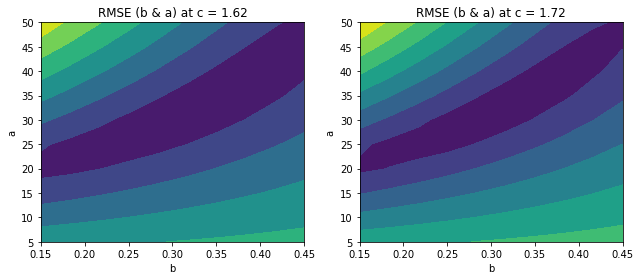

In [43]:
f, ax = plt.subplots(1,2,figsize=(9,4))
ic = 0 # select the first value of c
Qfit_temp = np.reshape(Qfit[:,:,ic],[10,10]);
ax[0].contourf(b,a,Qfit_temp)
ax[0].set_xlabel('b')
ax[0].set_ylabel('a')
ax[0].set_title('RMSE (b & a) at c = {}'.format(np.round(c[ic],2)))

ic = -1 # the last value of c (using the index "-1" to represent the last value in the array)
Qfit_temp2 = np.reshape(Qfit[:,:,ic],[10,10]);
ax[1].contourf(b,a,Qfit_temp2)
ax[1].set_xlabel('b')
ax[1].set_ylabel('a')
ax[1].set_title('RMSE (b & a) at c = {}'.format(np.round(c[ic],2)))

f.tight_layout()

The plots shows the RMSE distribution according to the change of a and b, according to the graph we can tell that whoever a or b increases the other one should also increase to get lower RMSE. Also c makes a relatively slight difference, but a and b vary with each other quite a bit.

## And then plot this as rating curves to see how our different parameter choices impact the spread c in estimated discharge as a function of h

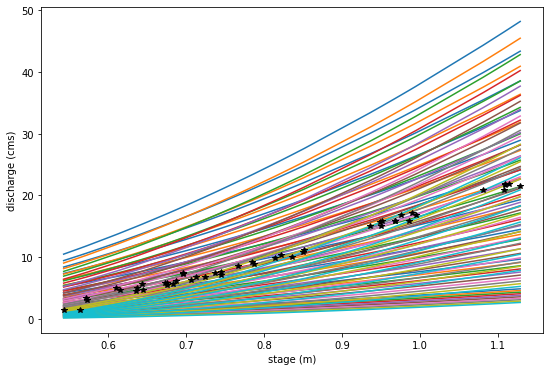

In [44]:
plt.figure(figsize=(9,6))
# Note, because c doesn't matter much, we will just choose a c value from the middle

for ia in range(nx):
    for ib in range(nx):
        plt.plot(h_now,np.reshape(Qest[ia,ib,5,:],h_now.size))

plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'k*')

## Then we sort out some lines that fits better.

In [45]:
# Reshape Qfit and Qest for a single c value to only look at variations of a and b
ic = 5
Qfit2 = np.reshape(Qfit[:,:,ic],[10,10])
Qest2 = np.reshape(Qest[:,:,ic,:],[10,10,h_now.size])

# Find the corresponding Qest values for different ranges of RMSE
Qest_rmse1 = Qest2[Qfit2<1]                # RMSE < 1
Qest_rmse3 = Qest2[(Qfit2>=1) & (Qfit2<3)] # 1 <= RMSE < 3
Qest_rmse5 = Qest2[(Qfit2>=3) & (Qfit2<5)] # 3 <= RMSE < 5

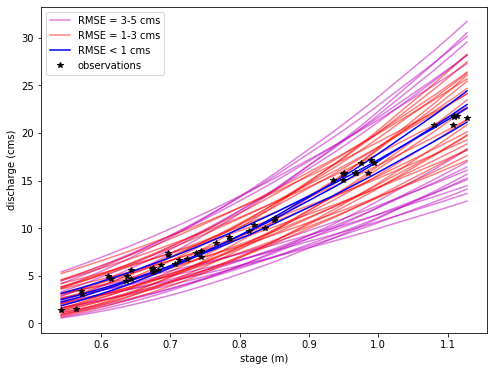

In [46]:
plt.figure(figsize=(8,6))

# Plot the rating curves with RMSE between 3 and 5 cms
for i in range(Qest_rmse5.shape[0]):
    if i ==0:
        label='RMSE = 3-5 cms'
    else:
        label=None
    plt.plot(h_now, Qest_rmse5[i],'m',alpha=0.5,label=label)
    
# Plot the rating curves with RMSE between 1 and 3 cms
for i in range(Qest_rmse3.shape[0]):
    if i ==0:
        label='RMSE = 1-3 cms'
    else:
        label=None
    plt.plot(h_now, Qest_rmse3[i],'r',alpha=0.5,label=label)
    
# Finally plot the rating curves with RMSE < 1 cms
for i in range(Qest_rmse1.shape[0]):
    if i ==0:
        label='RMSE < 1 cms'
    else:
        label=None
    plt.plot(h_now, Qest_rmse1[i],'b',alpha=1,label=label)

plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'k*',label='observations')
plt.legend();

Note that what we're starting to do here is to sort our rating curve parameter space into more likely and less likely parameter sets, based on how well they fit the data. However, this is imprecise, and we cannot quantify 95% uncertainty limits in any discharge estimation.

---
# PART 2:  Use MCMC to sample the parameter space.  

With uniform priors, this is very similar to the part 1 parameter estimation problem.

So, the above gives us an idea of Monte-Carlo parameter estimation but does not illustrate Bayesian or MCMC routines

I'm going to simplify to a two parameter problem, where I say that c=1.66 and that I know that (okay, not exactly true but it seemed to matter the least in this particular problem), and I'm going to start with the expected values from my priors for my initial guess.

This is kind of simplifying the model so MCMC method won't take too much time on this workflow.


In [47]:
b0 = 0.35 # New assumption
a0 = 30 # New assumption
c0 = 1.66 # and this one I won't vary

Now, we will ask the computer to navigate the parameter space. I will determine where to go according to how well my modeled Q fits my observed Q at all of my measurement points, with the understanding that the parameters that give me the minimum error are most likely to be true.

initial guess = likelihood = P(Q|theta), that's our model compared to our obs -- only need relative sense of error, so we look at the SSE's

In [48]:
Qest0 = a0 * (h_now-b0)**c0
SSE0 = np.sum((Qest0-Qobs_now)**2)
SSE0

153.04493258136992

In [49]:
# So, I set my limits of my uniform distribution
amin = 5
amax = 50
bmin = 0.15
bmax = 0.45

# for first step, I know I picked values in with the range, so 
P0 = 1

In [50]:
Lmc = 10000 #number of steps to run MCMC routine for.
burn_in = 1000 #estimate the number of steps before Markov Chain becomes stationary
# basically, the burn-in steps will not be used in calculating final probabilities because 
# they depend on the initial parameter estimates.

# Initialize arrays to store results in
PthetaQ = np.ones((Lmc,1))
amc = np.zeros((Lmc,1))
bmc = np.zeros((Lmc,1))

In [51]:
PthetaQ[0] = SSE0*P0 # this is our starting point.
    # Note that this calculation is not a true probability of P(theta|Q) but a relative metric
amc[0] = a0
bmc[0] = b0
# We save all the values at each step.

Now we start marching in MCMC space...

I need to randomly pick a new location. This is art, so I'm going to use two gaussians around my current location with sigma equal to the half-width of my prior distribution to pick a test jump location. I will use a Gibbs approach and jump in one variable followed by the other each time. (Note that a lot of the active research in MCMC code involves both how you pick your initial position and in how you pick your jumping strategy.)

I'm going to assume that my two parameters are totally independent (probably not true -- a next step would be to try a bivariate gaussian, but we stick with the simple case).

In [52]:
for imc in range(1,Lmc):
    
        # first we jump in a
    newjumpa = amc[imc-1] + (amax-amin)/(10*np.random.normal())
    
        # Now we repeat with a jump in b, assuming it's totally independent of a
        # and require both to be within their uniform distributions. 
        
    newjumpb = bmc[imc-1] + (bmax-bmin)/(10*np.random.normal())
    
    if (newjumpa >= amin) and (newjumpa <= amax) and (newjumpb >= bmin) and (newjumpb <= bmax):
        #then the prior is okay, and we can proceed 
        # (Note that prior makes any choice outside of our set range impossible)
        Qest1 = newjumpa*(h_now-newjumpb)**c0
        
        # calculate how well the parameters at our new location lead to a model that matches the data
        SSE1=np.sum((Qest1-Qobs_now)**2)
        
        # posterior is SSE1*1 (because we're within the prior uniform domain)
        # the if statement essentially says everything else is multiplied by 0
        
        if SSE1 < PthetaQ[imc-1]:
            # then the error is less, and we found a better place, and we update a and b
            amc[imc] = newjumpa
            bmc[imc] = newjumpb
            PthetaQ[imc] = SSE1 # this becomes the one to beat
        else:
            jumpscore = PthetaQ[imc-1]/SSE1 # this gives a number between 0 and 1
            
            # This is essentially a rating of how much worse this new location is than 
            # where you are right now.  The sum of squared errors is larger, but by how much
            
            # Generate random number from 0 to 1, so that we will jump with a probability of 
            # the jumpscore
            # if our new SSE is 90% as good as our current one, we jump there 90% of the time; 
            # if it's 10% as good, we jump there 10% of the time
            if np.random.uniform() <= jumpscore:
                # then we go there
                amc[imc] = newjumpa
                bmc[imc] = newjumpb
                PthetaQ[imc] = SSE1 # this becomes the one to beat
            else:
                amc[imc]=amc[imc-1]
                bmc[imc]=bmc[imc-1]
                PthetaQ[imc]=PthetaQ[imc-1] # we stay where we are for another timestep

    else:
    # you are outside of the bounds of the uniform prior, so posterior would be 0 and we don't go there
        amc[imc]=amc[imc-1]
        bmc[imc]=bmc[imc-1]
        PthetaQ[imc]=PthetaQ[imc-1] # we stay where we are


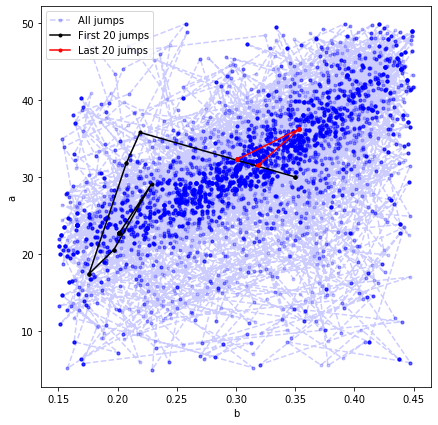

In [53]:
# Visualize all jumps across the a vs b parameter space
plt.figure(figsize=(7,7))
plt.plot(bmc,amc,'b.--',alpha=0.2,label='All jumps')
# Visualize the first 20 jumps
plt.plot(bmc[:20],amc[:20],'k.-',alpha=1,label='First 20 jumps')
# Visualize the last 20 jumps
plt.plot(bmc[-20:],amc[-20:],'r.-',alpha=1,label='Last 20 jumps')
plt.xlabel('b')
plt.ylabel('a')
plt.legend();

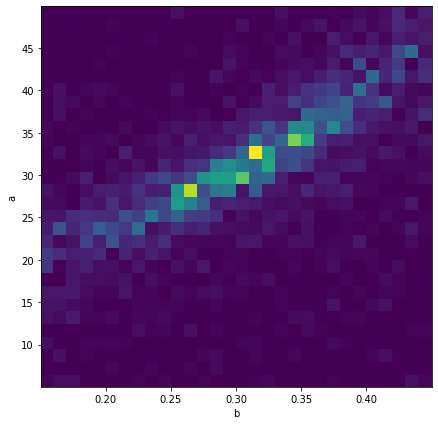

In [54]:
# "Heatmap" of all jumps across the a vs b parameter space
plt.figure(figsize=(7,7))
plt.hist2d(bmc.ravel(),amc.ravel(),30);
plt.xlabel('b')
plt.ylabel('a');

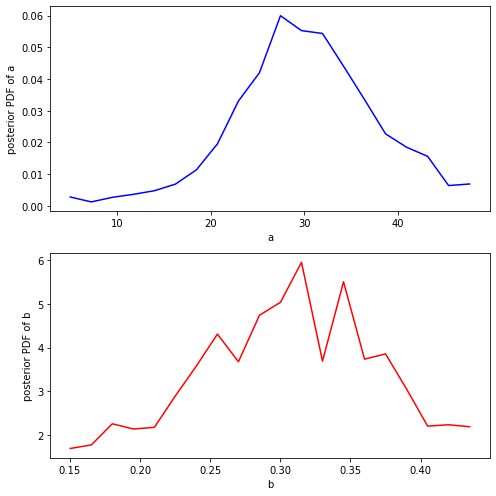

In [55]:
# What are the marginal PDFs for a and b?
a = plt.hist(amc[burn_in:],20);
b = plt.hist(bmc[burn_in:],20);
plt.close();

f, ax = plt.subplots(2,1,figsize=(7,7))
# A
ax[0].plot(a[1][:-1],a[0]/(np.sum(a[0])*(a[1][1]-a[1][0])),'b')
ax[0].set_xlabel('a')
ax[0].set_ylabel('posterior PDF of a')
# B
ax[1].plot(b[1][:-1],b[0]/(np.sum(b[0])*(b[1][1]-b[1][0])),'r')
ax[1].set_xlabel('b')
ax[1].set_ylabel('posterior PDF of b')
f.tight_layout()

## What are the 95% confidence intervals for the predicted Q

Note that by virtue of how we set up the jumping rules, the "jumper" spent more time in the good-fitting parameter space than in more poorly-fitting parameter space. Even better, it spent exactly as much time in the more poorly-fitting space as measured by how much worse it performed. By this structure, all calculated values of Q after the burn-in time are distributed by their liklihood of being right.

In [56]:
# evenly space 25 stage values (could have more if doesn't look smooth)
hh=np.linspace(0.54,1.5,25) 

# Make an empirical CDF for all calculated values of Q using a and b after the burn-in time 
# and plot the median and 95% confidence values from the Markov Chain generated probabilities
NN=amc[burn_in:].size

In [57]:
Q025 = np.ones((hh.shape))
Q50 = np.ones((hh.shape))
Q975 = np.ones((hh.shape))

for ih in range (hh.size):
    Qhh = amc[burn_in:]*(hh[ih]-bmc[burn_in:])**c0
    xsort = np.sort(Qhh[:,0])
    ranks = np.array(range(NN))+1
    x_CDF = 1 - (ranks - 0.4)/(NN + 0.2)
    
    Q025[ih] = np.interp(0.025,1-x_CDF,xsort)
    Q975[ih] = np.interp(0.975,1-x_CDF,xsort)
    Q50[ih] = np.interp(0.5,1-x_CDF,xsort)

Plot the median and 95% confidence values from the Markov Chain generated probabilities, note that this is only for the upper section of our data.

Text(0.5, 1.0, 'Best estimate with 95% confidence intervals')

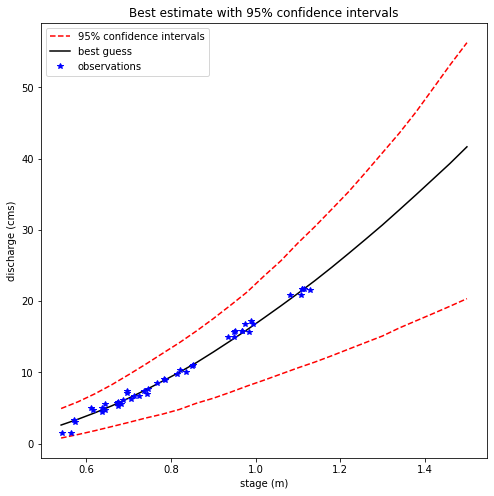

In [58]:
plt.figure(figsize=(8,8))
plt.plot(hh,Q025,'r--',label='95% confidence intervals')

plt.plot(hh,Q975,'r--')
plt.plot(hh,Q50,'k-',label='best guess')
plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'b*',label='observations')
plt.legend()
plt.title('Best estimate with 95% confidence intervals')

## Conclusion

As in part one, we basically visualized the influences from different parameters (a,b and c) on the RMSE between the real data point and our model. Then in part two, using MCMC method, we initialized with preset parameters (which could be based on the experience) and then adjust the parameters by jumping around based on certain algorithms. After the large times amount of 'jumping' we will get a certain range of parameters that can fit the real data well.

## Problem 3: Data Assimilation (20%)

Reading:	
reichle-2008.pdf

Read Reichle’s “Data assimilation methods in the Earth sciences”, available as reichle- 2008.pdf above and answer the following in your own words:

## A.

In the simple data assimilation system (section 2.1), what is the Kalman gain? What does it do, and why is it important?

Kalman gain (K) is the relative uncertainties from the model and observations. calculated as $$K=σ^2_m/(σ^2_m+σ^2_o)$$

Kalman gain gives the weight of models and observations, if the measured error variance is lower than the model uncertainty then more weight will be given to the observation, and vice versa.

The Kalman gain is important because it can give us the direction to update the model and calculate for the error variance of the assimilation estimate, thus give us more information about the true state x after assimilation.

## B.

According to Rolf Reichle, what are some of the greatest continuing challenges in data assimilation (see section 3)? List at least 3 and for each, give an example of how scientists are dealing with this challenge.

1. Input error covariances

The challenge is to deal with the model and observations that a input error covariances are known.

There are some stretagies towards it, such as the adaptive techniques during data assimilation and permit some measurement of automation. So far there are already applied on the soil moisture data assimilation.

2. Quality control

The challenge is to overcome the poor observations within an experiment.

Currently researchers working with soil moisture projects using some priori quality control to eliminate some poor data ahead from the observations. However this method is rarely sufficient for the data assimilation. Thus later on the on-line QC routines need to be added as part of the assimilation system.

3. Bias

The challenge is that theoratically the errors must be unbiased-strictly random and on average the model estimates and observations must agree with the true fields. However in practice there is never the case.

To overcome this challenge especially on the long term experiments, people using the normalized deviates or percentiles to somehow reduce the effects from the biases.